# Project Introduction

Understanding the intricate patterns and dynamics of electricity load is pivotal for efficient energy management. This project, entitled 'Day type identification of Algerian electricity load', delves into the identification of day types in the Algerian electricity load, employing a comprehensive approach that encompasses data analysis, visualization, and clustering techniques. The objective is to discern distinctive patterns and behaviors within the dataset, contributing to a nuanced understanding of consumption variations.

Through out this notebook, we will unravel the intricacies of day types in Algerian electricity load, employing data-driven methodologies to enhance our understanding and contribute to informed decision-making in the realm of energy consumption and resource allocation.

## Step1 :  Imports and first insight of the data

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hijri_converter import convert
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from kneed import KneeLocator 
from sklearn.neighbors import NearestNeighbors 
from sklearn.cluster import DBSCAN 
from collections import Counter 
from sklearn import metrics 
from sklearn.metrics import silhouette_score 
import numpy as np


import warnings
warnings.filterwarnings("ignore")

Before any further changes, we create 'original_df' to preserve the original dataset for reference throughout the notebook. This ensures that any modifications made during the analysis won't affect the original data. Any exploratory or preprocessing steps will be applied to 'df' while 'original_df' remains intact.

In [30]:
original_df = pd.read_csv('MyData.csv')
df=original_df.copy()

print(df.head())

                  time          pma       tmp
0  2016-01-01 00:00:00  1042.909320  6.933756
1  2016-01-01 01:00:00   982.529002  6.405644
2  2016-01-01 02:00:00   983.240592  5.932445
3  2016-01-01 03:00:00  1002.780354  5.503807
4  2016-01-01 04:00:00  1011.657004  5.112056


In [31]:
#show(dataframe, number_of_random_records_to_show)

def show(data, num_records=10):
        random_records = data.sample(n=num_records)
        print(random_records)
show(df, 5)

                      time          pma        tmp
5368   2016-08-11 16:00:00  1194.958335  27.556470
16221  2017-11-06 21:00:00  1225.419300  10.269041
5421   2016-08-13 21:00:00  1274.319337  21.885283
8438   2016-12-17 14:00:00  1453.348725  12.500000
12964  2017-06-24 04:00:00  1342.715558  19.233218


## Step 2: Cleaning data and preprocessing

Given that data is inherently untrustworthy, it becomes imperative to guarantee its integrity by ensuring cleanliness, which involves addressing issues such as missing values, duplicates, and outliers. Once this foundational step is complete, we proceed to the data preprocessing phase. Here, our main objective is to refine and structure the data in a way that aligns with our goal of classifying days into specific types based on electricity load characteristics.

In [32]:
# Check for missing values
print("Misiing values:")
print(df.isnull().sum())

# Check data types
print(df.dtypes)

# Check for duplicates
print(df.duplicated().sum())

# Statistical summary
print(df[['pma', 'tmp']].describe())

# Check time range
print("time rage")
print(df['time'].min(), df['time'].max())

Misiing values:
time    0
pma     0
tmp     0
dtype: int64
time     object
pma     float64
tmp     float64
dtype: object
0
                pma           tmp
count  17544.000000  17544.000000
mean    1270.591838     17.970785
std      256.451257      8.773332
min      558.397028     -1.377706
25%     1091.540361     10.855068
50%     1252.568251     17.281236
75%     1429.594974     24.250000
max     2174.951321     42.500000
time rage
2016-01-01 00:00:00 2017-12-31 23:00:00


### <span style="color:#7D0A0A;"> Adding attributes </span> 

To gain deeper insights from our data and facilitate seamless handling, we incorporate specific attributes. This addition not only simplifies interaction with the dataset but also enables us to extract additional information.

In [33]:
#adding attribute : Date
df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date

In [34]:
#adding attribute :hour
df['hour'] = df['time'].dt.hour

In [35]:
#adding attribute : month (from 1 to 12 values)
df['month'] = pd.to_datetime(df['time']).dt.month_name()
month_mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
                 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
df['month'] = df['month'].map(month_mapping)

In [36]:
#adding attribute : days of week (monday :0,... sunday :6)
df['day_of_week'] = df['time'].dt.dayofweek

In [37]:
# Add 'season' column based on month
season_mapping = {1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 3, 7: 3, 8: 3, 9: 4, 10: 4, 11: 4, 12: 1}
df['season'] = df['month'].map(season_mapping)

In [38]:

scaler = MinMaxScaler()
df[['pma_normalized', 'tmp_normalized']] = scaler.fit_transform(df[['pma', 'tmp']])

In [39]:
# Create historical features considering a window size of 7 days (24 hours * 7 days)
window_size = 24 * 7  # 7 days

# Calculate sum and average of historical PMA for each hour
df['sum_previous_pma'] = df['pma'].rolling(window=window_size, min_periods=1).sum().shift(24)
df['avg_previous_pma'] = df['pma'].rolling(window=window_size, min_periods=1).mean().shift(24)

df['sum_previous_pma'].fillna(0, inplace=True)
df['avg_previous_pma'].fillna(0, inplace=True)

In [40]:
# Create an indicator for weekends (Saturday and Friday
df['is_weekend'] = df['time'].dt.dayofweek.isin([4, 5]).astype(int)

In [41]:
#Adding attribute is_holiday considering algerian occasions

# Normal calendar dates map (without the year) using integer representation
normal_calendar_dates = {
    "01-01": "New Year's Day",
    "01-12": "Special Occasion",
    "05-01": "Labor Day",
    "07-05": "Independence Day",
    "11-01": "Special Occasion"
}
# Convert 'date' column to datetime format if it's not already
df['date'] = pd.to_datetime(df['date'])

# Extract month and day into a new column 'month_day'
df['month_day'] = df['date'].dt.strftime("%m-%d")
def is_islamic_new_year(gregorian_date):
    # Convert the provided Gregorian date to Hijri
    gregorian_datetime = datetime.strptime(gregorian_date, "%Y-%m-%d")
    year, month, day = gregorian_datetime.year, gregorian_datetime.month, gregorian_datetime.day
    hijri_date = convert.Gregorian(year, month, day).to_hijri()
    
    # Check if it's the first day of Muharram (Islamic New Year)
    return hijri_date.day == 1 and hijri_date.month == 1

def is_first_day_of_ramadan(gregorian_date):
    # Convert the provided Gregorian date to Hijri
    gregorian_datetime = datetime.strptime(gregorian_date, "%Y-%m-%d")
    year, month, day = gregorian_datetime.year, gregorian_datetime.month, gregorian_datetime.day
    hijri_date = convert.Gregorian(year, month, day).to_hijri()
    
    # Check if it's the first day of Ramadan
    return hijri_date.day == 1 and hijri_date.month == 9

def is_eid_el_fitr_holiday(gregorian_date):
    # Convert the provided Gregorian date to Hijri
    gregorian_datetime = datetime.strptime(gregorian_date, "%Y-%m-%d")
    year, month, day = gregorian_datetime.year, gregorian_datetime.month, gregorian_datetime.day
    hijri_date = convert.Gregorian(year, month, day).to_hijri()
    
    # Eid al-Fitr is celebrated on the 1st day of Shawwal (10th month)
    return hijri_date.day == 1 and hijri_date.month == 10

def is_eid_el_adha_holiday(gregorian_date):
    # Convert the provided Gregorian date to Hijri
    gregorian_datetime = datetime.strptime(gregorian_date, "%Y-%m-%d")
    year, month, day = gregorian_datetime.year, gregorian_datetime.month, gregorian_datetime.day
    hijri_date = convert.Gregorian(year, month, day).to_hijri()
    
    # Eid al-Adha is celebrated on the 10th day of Dhu al-Hijjah (12th month)
    return hijri_date.day == 10 and hijri_date.month == 12

def is_achoura_holiday(gregorian_date):
    # Convert the provided Gregorian date to Hijri
    gregorian_datetime = datetime.strptime(gregorian_date, "%Y-%m-%d")
    year, month, day = gregorian_datetime.year, gregorian_datetime.month, gregorian_datetime.day
    hijri_date = convert.Gregorian(year, month, day).to_hijri()
    
    # Achoura is celebrated on the 10th day of Muharram (1st month)
    return hijri_date.day == 10 and hijri_date.month == 1

def is_el_mawlid_el_nabawiy_holiday(gregorian_date):
    # Convert the provided Gregorian date to Hijri
    gregorian_datetime = datetime.strptime(gregorian_date, "%Y-%m-%d")
    year, month, day = gregorian_datetime.year, gregorian_datetime.month, gregorian_datetime.day
    hijri_date = convert.Gregorian(year, month, day).to_hijri()
    
    # El Mawlid El Nabawiy is celebrated on the 12th day of Rabi' al-Awwal (3rd month)
    return hijri_date.day == 12 and hijri_date.month == 3

def is_holiday(gregorian_date):
    gregorian_datetime = datetime.strptime(gregorian_date, "%Y-%m-%d")
    year, month, day = gregorian_datetime.year, gregorian_datetime.month, gregorian_datetime.day
    
    for offset in range(-1, 2):
        current_date = gregorian_datetime + timedelta(days=offset)
        hijri_date = convert.Gregorian(current_date.year, current_date.month, current_date.day).to_hijri()
        
        if (
            is_islamic_new_year(current_date.strftime("%Y-%m-%d")) or
            is_first_day_of_ramadan(current_date.strftime("%Y-%m-%d")) or
            is_eid_el_fitr_holiday(current_date.strftime("%Y-%m-%d")) or
            is_eid_el_adha_holiday(current_date.strftime("%Y-%m-%d")) or
            is_achoura_holiday(current_date.strftime("%Y-%m-%d")) or
            is_el_mawlid_el_nabawiy_holiday(current_date.strftime("%Y-%m-%d"))
        ):
            return 1  # It's a holiday
    return 0  # It's not a holiday

# Apply the function to create a new column 'is_holiday'
df['date'] = df['date'].astype(str)

# Apply the 'is_holiday' function and the normal_calendar_dates check to create the 'is_holiday' column
df['is_holiday'] = ((df['date'].apply(lambda x: is_holiday(x))) | (df['month_day'].isin(normal_calendar_dates.keys()))).astype(int)

In [42]:
show(df)

                     time          pma        tmp        date  hour  month  \
8132  2016-12-04 20:00:00  1699.597411  12.455858  2016-12-04    20     12   
14337 2017-08-20 09:00:00  1362.775390  29.315176  2017-08-20     9      8   
11339 2017-04-17 11:00:00  1160.938100  22.340230  2017-04-17    11      4   
1940  2016-03-21 20:00:00  1419.444525  15.956098  2016-03-21    20      3   
7730  2016-11-18 02:00:00  1207.528734  10.355388  2016-11-18     2     11   
16541 2017-11-20 05:00:00  1162.930941   4.615812  2017-11-20     5     11   
16106 2017-11-02 02:00:00   922.040900   9.977836  2017-11-02     2     11   
12428 2017-06-01 20:00:00  1451.353940  23.465170  2017-06-01    20      6   
15749 2017-10-18 05:00:00   958.452698  11.638781  2017-10-18     5     10   
11193 2017-04-11 09:00:00  1140.317591  14.379537  2017-04-11     9      4   

       day_of_week  season  pma_normalized  tmp_normalized  sum_previous_pma  \
8132             6       1        0.705946        0.315275   

In [43]:
print(df.dtypes)

time                datetime64[ns]
pma                        float64
tmp                        float64
date                        object
hour                         int32
month                        int64
day_of_week                  int32
season                       int64
pma_normalized             float64
tmp_normalized             float64
sum_previous_pma           float64
avg_previous_pma           float64
is_weekend                   int64
month_day                   object
is_holiday                   int64
dtype: object


### <span style="color:#7D0A0A;"> Summary of Added Attributes: </span> 

Here's a brief overview of the new attributes we've added to our dataset:

<span style="color:#7D0A0A;"> 'date' and 'hour': </span> 
Purpose: Separating the 'time' attribute for future precise timestamp analysis.

<span style="color:#7D0A0A;"> 'month' and 'day_of_week': </span> 
Purpose: Extracting the 'season' of each record, laying the foundation for seasonal analysis.

<span style="color:#7D0A0A;"> 'sum_previous_pma' and 'avg_previous_pma': </span> 
Purpose: Providing insights into the relationship between previous consumption and current values.

<span style="color:#7D0A0A;"> 'is_weekend' and 'is_holiday':</span> 
Purpose: Aiding future clustering for day classification, with 'is_holiday' specifically identifying Islamic and national holidays.

<span style="color:#7D0A0A;"> Note:</span> 
We took rigorous steps to normalize necessary data and fill null records.
Additional attributes may be introduced based on their potential contributions to effective dataset handling

## Step 3: Analysing and visualizing data

Through a combination of exploratory and explanatory visualizations, our goal is to gain a holistic understanding of the data, extracting actionable insights so that we will be able to identify the day types at the end.

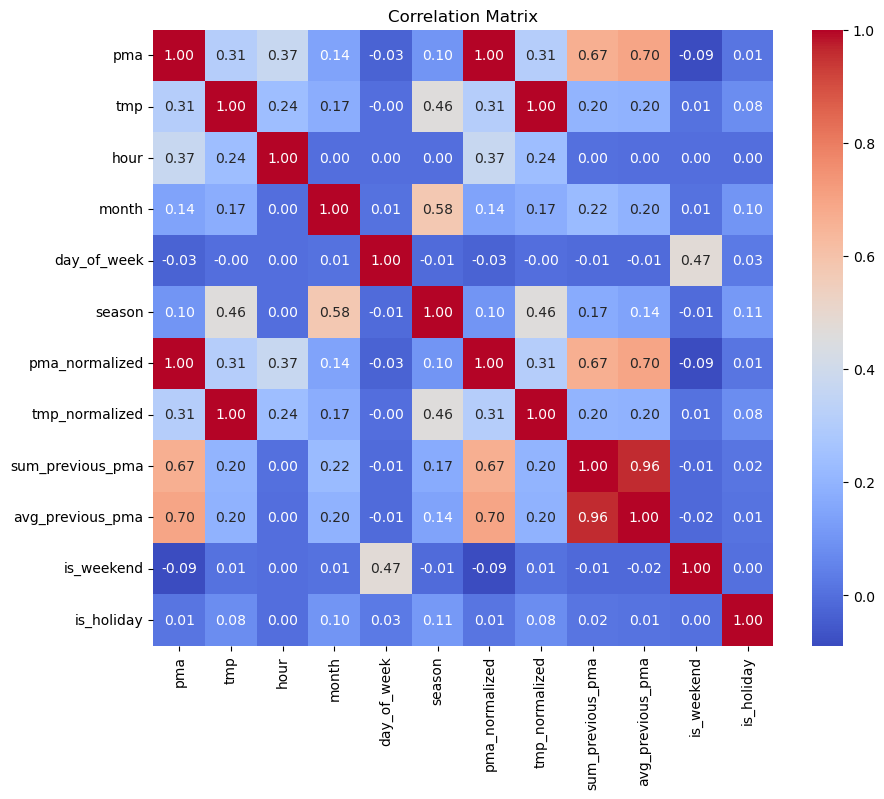

In [44]:
# Drop non-numeric columns before correlation analysis
numeric_df = df.select_dtypes(include=['float64', 'int32', 'int64'])  # Select only numeric columns

# Correlation matrix
corr_matrix = numeric_df.corr()

# Heatmap for correlation visualization
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()



### <span style="color:#7D0A0A;"> Heatmap Analysis </span> 

Based on the findings from the heatmap analysis, it becomes evident that the most correlated attributes to `pma` are `tmp` , `hour`, `month` compared to other attributes.
Reasonable correlations between 'season' and 'month,' as well as 'tmp' and also between 'day_of_week' and 'is_weekend.' 

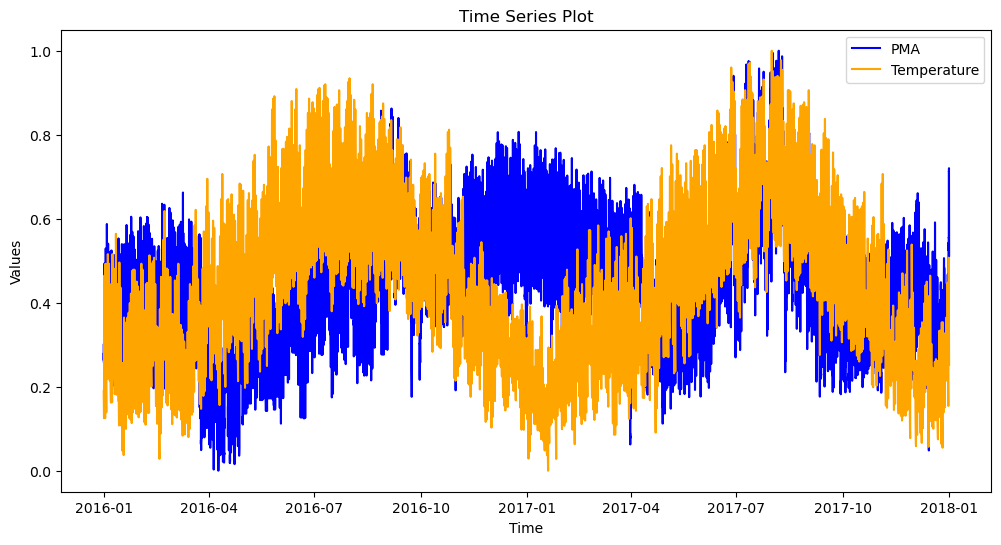

In [45]:
# Time Series Plots
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['pma_normalized'], label='PMA', color='blue')
plt.plot(df['time'], df['tmp_normalized'], label='Temperature', color='orange')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Time Series Plot')
plt.legend()
plt.show()


### <span style="color:#7D0A0A;"> Result: Time Series Plots </span> 

The time series plot illustrates the variation of key attributes over time. Two primary variables, 'PMA' (blue line) and 'Temperature' (orange line), are visualized, allowing for a dynamic representation of their temporal patterns. The x-axis denotes time, while the y-axis represents the normalized values of the respective attributes. 

This visualization clarifies how 'PMA' and 'Temperature' fluctuate over time, indicating a notable alignment between the two variables.

Note that the normalization of values is essential because 'Temperature' and 'PMA' have different scales, and bringing them to a common scale ensures a meaningful and fair comparison in the time series plot.


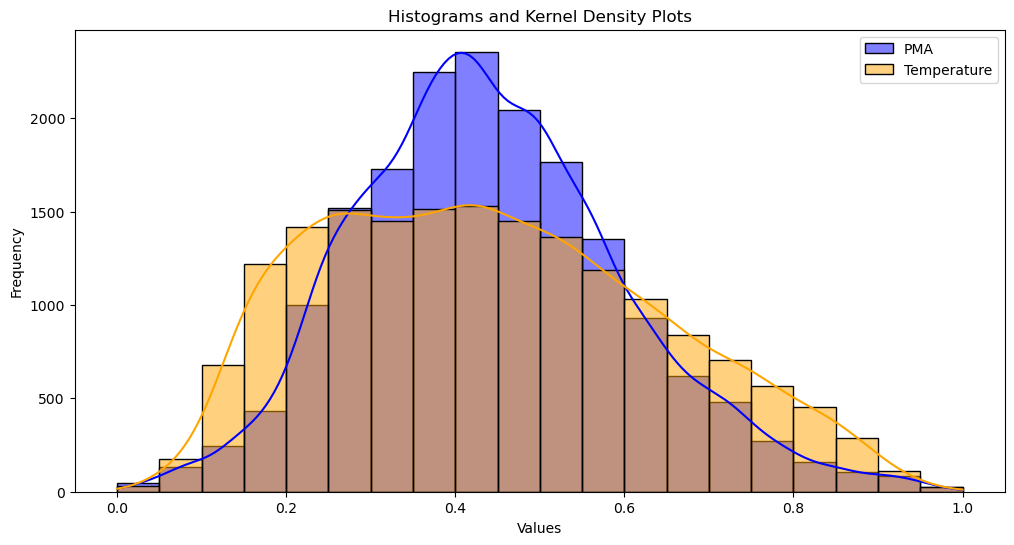

In [46]:
# Histograms and Kernel Density Plots
plt.figure(figsize=(12, 6))
sns.histplot(df['pma_normalized'], bins=20, kde=True, color='blue', label='PMA')
sns.histplot(df['tmp_normalized'], bins=20, kde=True, color='orange', label='Temperature')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms and Kernel Density Plots')
plt.legend()
plt.show()

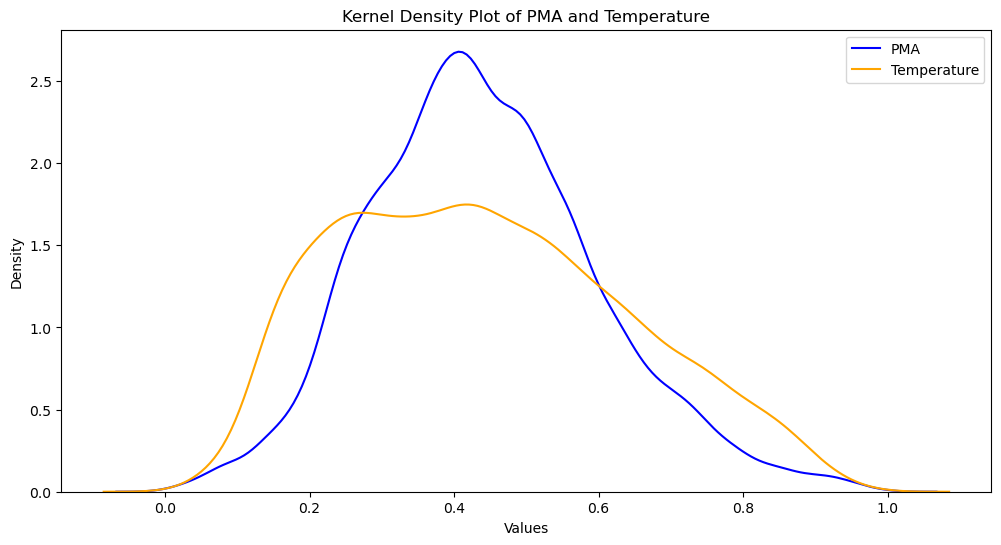

In [47]:
# Feature Distribution Plots
plt.figure(figsize=(12, 6))
sns.kdeplot(df['pma_normalized'], color='blue', label='PMA')
sns.kdeplot(df['tmp_normalized'], color='orange', label='Temperature')
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Kernel Density Plot of PMA and Temperature')
plt.legend()
plt.show()

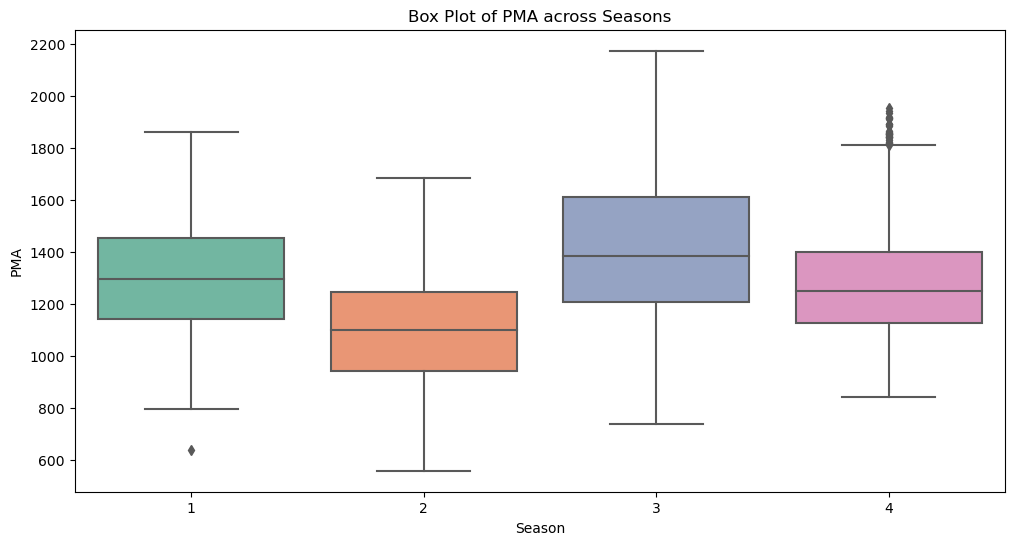

In [48]:
# Box Plots
plt.figure(figsize=(12, 6))
sns.boxplot(x='season', y='pma', data=df, palette='Set2')
plt.xlabel('Season')
plt.ylabel('PMA')
plt.title('Box Plot of PMA across Seasons')
plt.show()


In [49]:
filter_conditions = {
    'season_1_low_pma': (df['season'] == 1) & (df['pma'] < 650),
    'season_4_high_pma':(df['season'] == 4) & (df['pma'] > 1800),
}

# Apply filters and get rows with outliers
outliers = df[filter_conditions['season_1_low_pma'] | filter_conditions['season_4_high_pma']]

# Display the rows with outliers
print(outliers)

                     time          pma        tmp        date  hour  month  \
5923  2016-09-03 19:00:00  1807.669222  26.844758  2016-09-03    19      9   
5924  2016-09-03 20:00:00  1867.403501  24.113001  2016-09-03    20      9   
5925  2016-09-03 21:00:00  1831.300937  22.291425  2016-09-03    21      9   
5926  2016-09-03 22:00:00  1801.634683  20.922799  2016-09-03    22      9   
5947  2016-09-04 19:00:00  1892.965591  26.783583  2016-09-04    19      9   
5948  2016-09-04 20:00:00  1893.712996  25.068776  2016-09-04    20      9   
5949  2016-09-04 21:00:00  1884.029106  23.921583  2016-09-04    21      9   
5950  2016-09-04 22:00:00  1855.363879  23.058275  2016-09-04    22      9   
5965  2016-09-05 13:00:00  1811.422493  34.977094  2016-09-05    13      9   
5966  2016-09-05 14:00:00  1860.170182  35.250000  2016-09-05    14      9   
5967  2016-09-05 15:00:00  1843.917610  34.977094  2016-09-05    15      9   
5971  2016-09-05 19:00:00  1944.263590  28.267555  2016-09-05   

### <span style="color:#7D0A0A;"> Outliers Analyses: </span> 
This section of the code is designed to analyze outliers, aiming to verify whether they are associated with the temperature attribute.

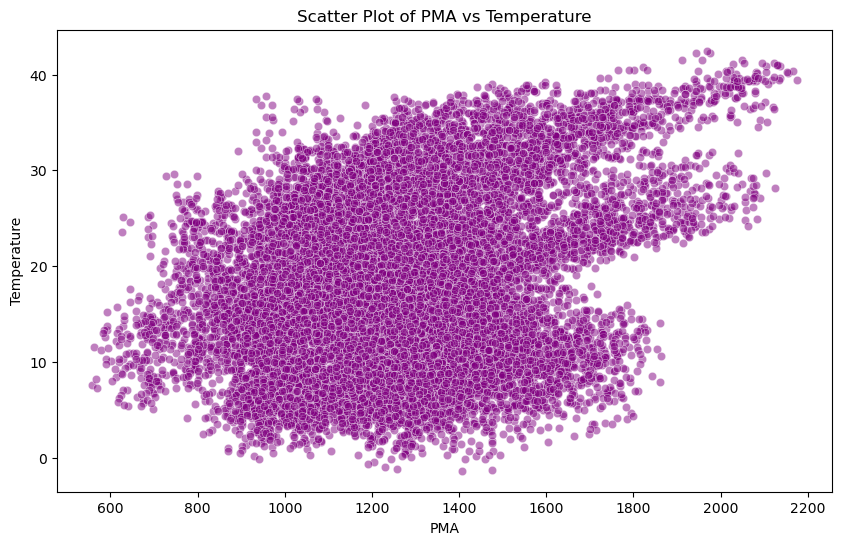

In [50]:
# Scatter Plots
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pma', y='tmp', data=df, color='purple', alpha=0.5)
plt.xlabel('PMA')
plt.ylabel('Temperature')
plt.title('Scatter Plot of PMA vs Temperature')
plt.show()


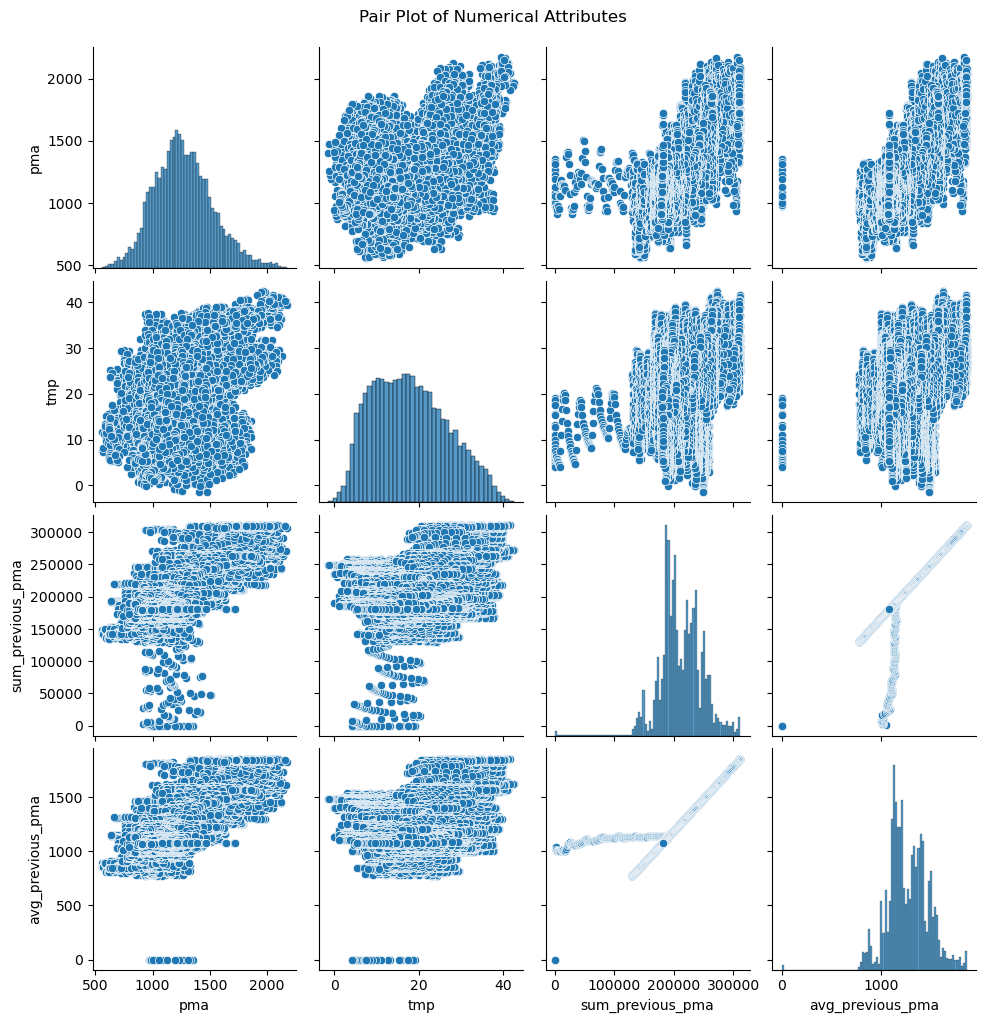

In [51]:
# Pair Plots
sns.pairplot(df[['pma', 'tmp', 'sum_previous_pma', 'avg_previous_pma']])
plt.suptitle('Pair Plot of Numerical Attributes', y=1.02)
plt.show()



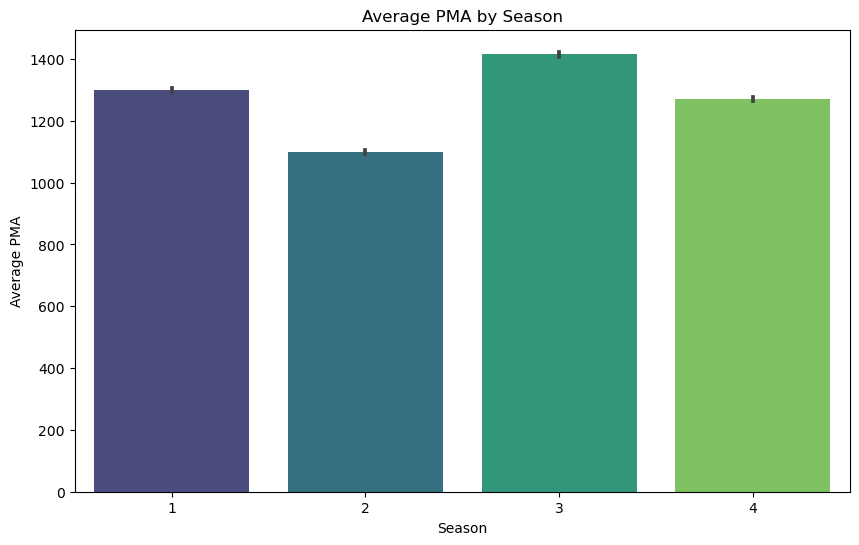

In [52]:
# Seasonal Trends
plt.figure(figsize=(10, 6))
sns.barplot(x='season', y='pma', data=df, palette='viridis')
plt.xlabel('Season')
plt.ylabel('Average PMA')
plt.title('Average PMA by Season')
plt.show()

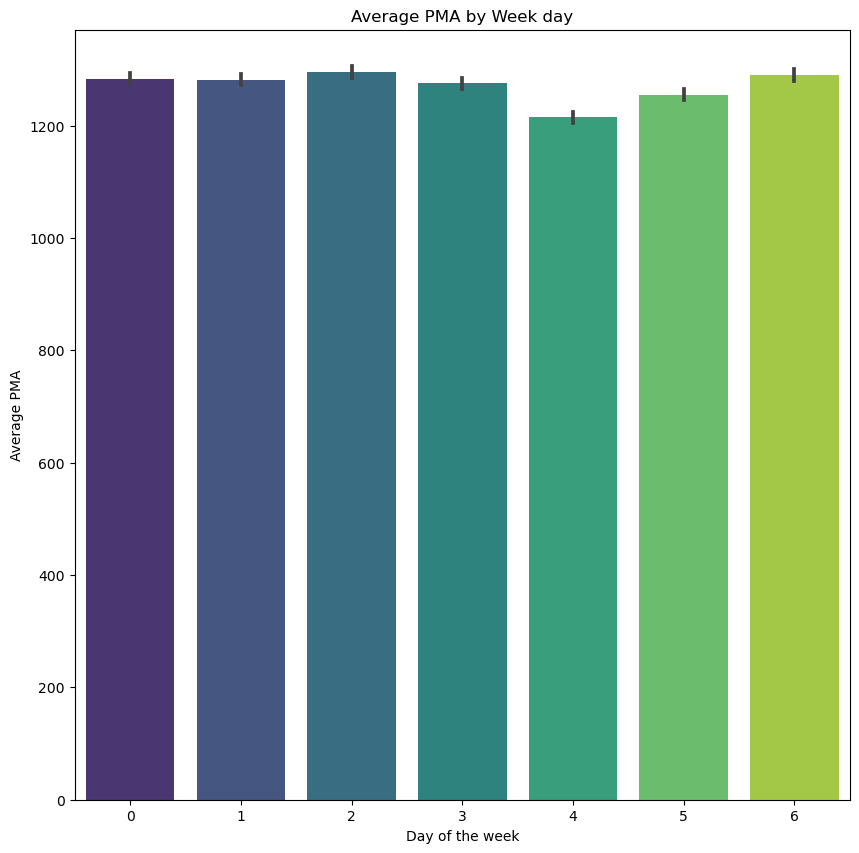

In [53]:
# Day of Week Trends
plt.figure(figsize=(10, 10))
sns.barplot(x='day_of_week', y='pma', data=df, palette='viridis')
plt.xlabel('Day of the week')
plt.ylabel('Average PMA')
plt.title('Average PMA by Week day')
plt.show()

### <span style="color:#7D0A0A;"> According to the previous visualizations: </span> 
The diverse visualizations have played a crucial role in interpreting and understanding the dataset. They provided valuable insights into how various attributes align with each other. Additionally, these visualizations have offered clarity on the next steps, guiding the process of clustering and labeling our dataset. The visual exploration has not only enhanced comprehension but also paved the way for informed decision-making in the subsequent stages of our analysis.

It's worth noting that while some visualizations may not have been strictly essential, they served a crucial role in providing confirmation and clarity to certain aspects of the analysis. 

## Step 4:  Clustering

In the pursuit of identifying the day types of Algerian electricity load, the application of clustering methods becomes indispensable. Clustering serves as a vital tool, allowing us to group similar patterns and behaviors within the dataset. This methodological approach is crucial for achieving our overarching goal of discerning distinct day types based on electricity load characteristics.

### DBSCAN

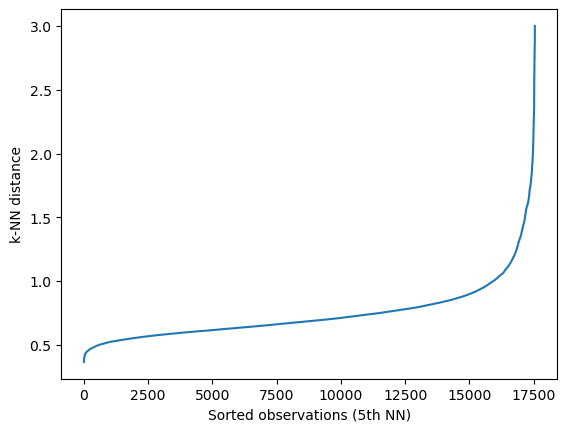

In [54]:
# Extracting relevant features for clustering 
features = ['pma', 'tmp', 'hour', 'month', 'day_of_week', 'season','avg_previous_pma', 'is_weekend', 'is_holiday'] 
X = df[features] 
# Normalize the data 
scaler = StandardScaler() 
X_normalized = scaler.fit_transform(X) 
 

# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros)  
nbrs = NearestNeighbors(n_neighbors = 20).fit(X_normalized) 
# Find the k-neighbors of a point 
neigh_dist, neigh_ind = nbrs.kneighbors(X_normalized) 
# sort the neighbor distances (lengths to points) in ascending order 
# axis = 0 represents sort along first axis i.e. sort along row 
sort_neigh_dist = np.sort(neigh_dist, axis = 0) 
k_dist = sort_neigh_dist[:, 19] 
plt.plot(k_dist) 
plt.ylabel("k-NN distance") 
plt.xlabel("Sorted observations (5th NN)") 
plt.show()

2.7539329661716585


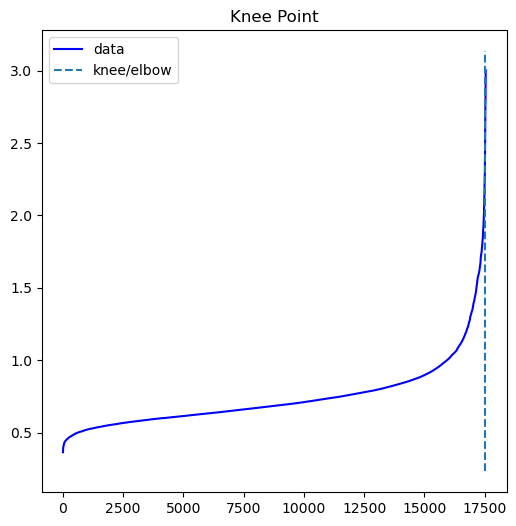

Ellipsis

In [55]:

kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, S = 1.0,  
                      curve = "concave", direction = "increasing", online=True) 
 
# get the estimate of knee point 
print(kneedle.knee_y) 
kneedle.plot_knee() 
plt.show()

clusters = DBSCAN(eps = 2.75, min_samples = 20).fit(X_normalized) 
# get cluster labels 
clusters.labels_ 
 
# check unique clusters 
set(clusters.labels_) 
 
# -1 value represents noisy points could not assigned to any cluster

#Get each cluster size, 
...

In [56]:
# Define a range of parameter values to try 
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0] 
min_samples_values = [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 30] 
 
best_silhouette_score = 1 
best_eps = None 
best_min_samples = None 
 
# Perform grid search 
for eps in eps_values: 
    for min_samples in min_samples_values: 
        clusters = DBSCAN(eps=eps, min_samples=min_samples).fit(X_normalized) 
        silhouette = silhouette_score(X_normalized, clusters.labels_) 
         
        print(f"Parameters: eps={eps}, min_samples={min_samples}, Silhouette Score: {silhouette}") 
         
        if silhouette > best_silhouette_score: 
            best_silhouette_score = silhouette 
            best_eps = eps 
            best_min_samples = min_samples 
 
print(f"Best Parameters: eps={best_eps}, min_samples={best_min_samples}, Best Silhouette Score: {best_silhouette_score}")

Parameters: eps=0.5, min_samples=16, Silhouette Score: -0.3812048147129489
Parameters: eps=0.5, min_samples=17, Silhouette Score: -0.3971724096041762
Parameters: eps=0.5, min_samples=18, Silhouette Score: -0.40302604482241605
Parameters: eps=0.5, min_samples=19, Silhouette Score: -0.40565916815638103
Parameters: eps=0.5, min_samples=20, Silhouette Score: -0.4040611271534165
Parameters: eps=0.5, min_samples=21, Silhouette Score: -0.400038734220931
Parameters: eps=0.5, min_samples=22, Silhouette Score: -0.41097382697396667
Parameters: eps=0.5, min_samples=23, Silhouette Score: -0.4117293645212366
Parameters: eps=0.5, min_samples=24, Silhouette Score: -0.41576976048318587
Parameters: eps=0.5, min_samples=25, Silhouette Score: -0.4059693011158253
Parameters: eps=0.5, min_samples=30, Silhouette Score: -0.2281882786234737
Parameters: eps=1.0, min_samples=16, Silhouette Score: 0.08739012379814108
Parameters: eps=1.0, min_samples=17, Silhouette Score: 0.08601196357017692
Parameters: eps=1.0, m

##### Testing for analysis:

In [57]:

Counter(clusters.labels_)
 
print(f"Silhouette Coefficient: {metrics.silhouette_score(X_normalized, clusters.labels_):.3f}")

# Get cluster labels and unique clusters 
cluster_labels = clusters.labels_ 
unique_clusters = set(cluster_labels) 
 
# Define the number of points to display for each cluster 
points_to_display = 30 
 
# Iterate over unique cluster labels 
for cluster_id in unique_clusters: 
    if cluster_id == -1: 
        # Noise points 
        noise_indices = np.where(cluster_labels == cluster_id)[0] 
        print(f"Noise Points: {len(noise_indices)} points, Indices: {noise_indices}") 
    else: 
        # Core and border points in the cluster 
        cluster_indices = np.where(cluster_labels == cluster_id)[0] 
        print(f"Cluster {cluster_id}: {len(cluster_indices)} points, Indices: {cluster_indices}") 
 
        # Display values of 'pma' and 'tmp' attributes for some points in the cluster 
        sample_points = cluster_indices[:points_to_display] 
        cluster_values = df.loc[sample_points, ['pma', 'tmp','month' ]] 
        print(f"Sample Points in Cluster {cluster_id}:\n{cluster_values}")


Silhouette Coefficient: 0.331
Cluster 0: 16464 points, Indices: [   24    25    26 ... 17541 17542 17543]
Sample Points in Cluster 0:
            pma        tmp  month
24   978.905006   6.823037      1
25   958.558718   6.317435      1
26   913.428220   5.864429      1
27   942.648352   5.454100      1
28   975.513715   5.079094      1
29   954.812768   4.733810      1
30  1055.985031   4.413880      1
31  1054.263259   4.115833      1
32  1161.262641   7.522648      1
33  1184.093237  10.965865      1
34  1154.922474  14.066355      1
35  1147.704328  16.662891      1
36  1143.655353  18.620453      1
37  1131.686318  19.837248      1
38  1133.458397  20.250000      1
39  1096.857384  19.837248      1
40  1103.536545  18.620453      1
41  1366.451308  16.425713      1
42  1413.860620  13.639426      1
43  1410.281140  11.949103      1
44  1391.509122  10.732053      1
45  1316.913532   9.780416      1
46  1225.454631   8.998905      1
47  1071.232562   8.335820      1
48   963.531295 

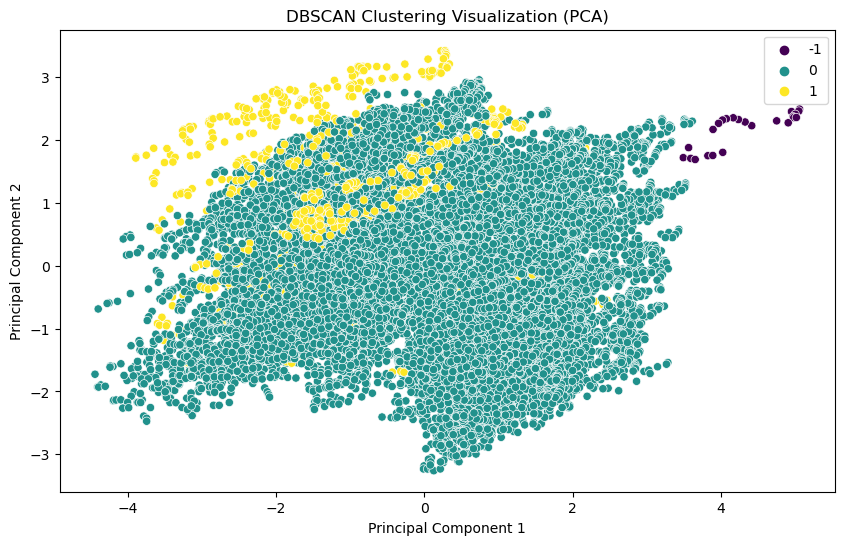

In [58]:
# Apply PCA to reduce dimensions to 2 
pca = PCA(n_components=2) 
df_pca = pd.DataFrame(pca.fit_transform(X_normalized), columns=['PCA1', 'PCA2']) 
df_pca["cluster_labels"] = clusters.labels_ 
 
# Scatter plot colored by cluster labels 
plt.figure(figsize=(10, 6)) 
sns.scatterplot(x='PCA1', y='PCA2', hue=clusters.labels_, data=df_pca, palette='viridis') 
plt.title('DBSCAN Clustering Visualization (PCA)') 
plt.xlabel('Principal Component 1') 
plt.ylabel('Principal Component 2') 
plt.show()

#### CONCLUSION

As an initial clustering method, DBSCAN was chosen. Therefore, it's necessary to select its parameters, such as minPTS and radius. For minPTS, we employed the general method of using the number of attributes multiplied by 2, and for the radius, we applied the knee method. To obtain more specific values, we conducted multiple tests with different values of minPTS and radius, as shown above. 

However, while evaluating using the silhouette method, it yielded small values. Therefore, we decided to work with another method, which is k-means.

### K-Means

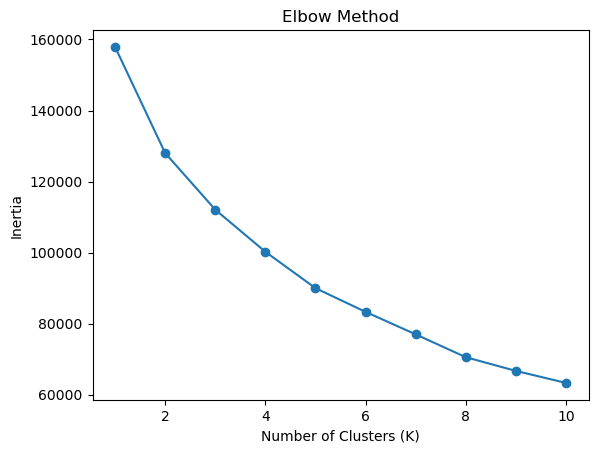

In [59]:
# Select features for clustering
features = ['pma', 'tmp', 'hour', 'month', 'day_of_week', 'season','avg_previous_pma', 'is_weekend', 'is_holiday']
X = df[features]

# Normalize the data
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
# Elbow Method to find the optimal number of clusters (K)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_normalized)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

Our analysis and visualization emphasize the significance of features such as 'pma', 'tmp', 'hour', 'month', 'day_of_week', 'season', 'avg_previous_pma', 'is_weekend', and 'is_holiday' for effective clustering. These features offer valuable insights into electricity consumption patterns. 


In [60]:
# Extracting relevant features for clustering
features = ['pma', 'tmp', 'hour', 'month', 'day_of_week', 'season','avg_previous_pma', 'is_weekend', 'is_holiday']
X = df[features]

# Standardizing the features (important for K-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # You can adjust the number of clusters
df['cluster_label'] = kmeans.fit_predict(X_scaled)


The selection of the cluster count is informed by insights obtained in earlier analyses of different visualizations (the elbow method), ensuring a data-driven and informed choice for the clustering process.

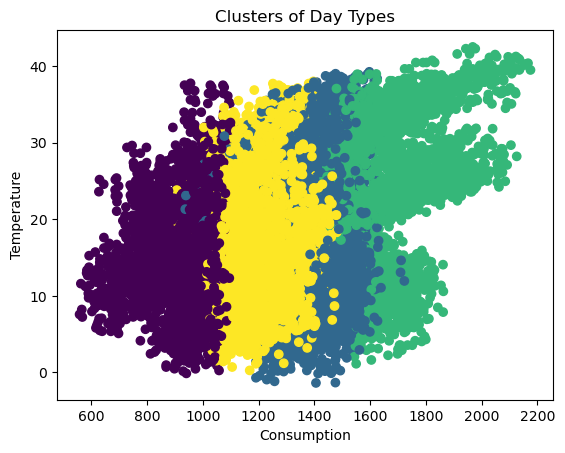

In [61]:
# Choose the optimal number of clusters (e.g., 3, based on the Elbow Method)
optimal_k = 4

# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=0)
df['cluster'] = kmeans.fit_predict(X)

# Visualize the clusters
plt.scatter(df['pma'], df['tmp'], c=df['cluster'], cmap='viridis')
plt.title('Clusters of Day Types')
plt.xlabel('Consumption')
plt.ylabel('Temperature')
plt.show()

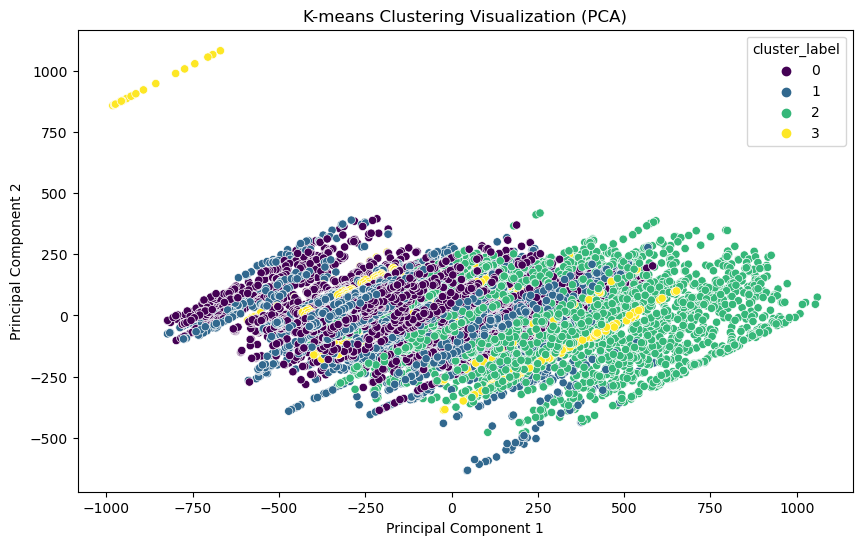

In [62]:

pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(df[features]), columns=['PCA1', 'PCA2'])
df_pca['cluster_label'] = df['cluster_label']

# Scatter plot colored by cluster labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster_label', data=df_pca, palette='viridis')
plt.title('K-means Clustering Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

We use PCA for a 2D visualization, simplifying the understanding of feature distribution and data point separation.

In [63]:
X = df.drop(['time', 'date','month_day','sum_previous_pma'], axis=1)
cluster_characteristics = X.groupby('cluster_label').mean()  # Use mean() or median() based on your preference

# Display the characteristics of each cluster
print(cluster_characteristics)

                       pma        tmp       hour     month  day_of_week  \
cluster_label                                                             
0              1182.864278  13.492944  11.162304  4.047796     2.346901   
1              1190.923741  16.907523  11.161115  6.355540     4.519828   
2              1410.220441  22.594440  12.070147  8.792496     2.521044   
3              1284.561152  20.621217  11.500000  7.844444     3.222222   

                 season  pma_normalized  tmp_normalized  avg_previous_pma  \
cluster_label                                                               
0              1.614085        0.386295        0.338911       1180.047645   
1              2.401314        0.391281        0.416732       1239.379640   
2              3.344535        0.526938        0.546340       1373.895164   
3              3.000000        0.449205        0.501369       1277.093172   

               is_weekend  is_holiday   cluster  
cluster_label                       

This step is crucial for a clear understanding of our clusters, enabling accurate assignment of labels so that we calculate the mean values of each attributes.

### <span style="color:#7D0A0A;"> Observation: </span> 
As noticed, there is a cluster that only includes holiday type of days (cluster 3). In addition, cluster 1 only contains weekend days (99%). Hence, To understand the other clusters, we need to study how other features manifest on each of them. 

In [64]:
# Convert 'date' column to datetime if it's not already
df['date'] = pd.to_datetime(df['date'])

# Function to identify the start of Ramadan
def is_first_day_of_ramadan(gregorian_date):
    gregorian_datetime = gregorian_date.to_pydatetime()
    year, month, day = gregorian_datetime.year, gregorian_datetime.month, gregorian_datetime.day
    hijri_date = convert.Gregorian(year, month, day).to_hijri()

    # Check if it's the first day of Ramadan (month 9 in the Hijri calendar)
    return hijri_date.month == 9 and hijri_date.day == 1

# Initialize 'is_ramadan' column with zeros
df['is_ramadan'] = 0

# Identify the start of Ramadan and update 'is_ramadan' attribute
ramadan_start = None
for i, row in df.iterrows():
    if is_first_day_of_ramadan(row['date']):
        ramadan_start = row['date']

    # Check if the current date is within 28 days after the start of Ramadan
    if ramadan_start and (row['date'] - ramadan_start).days < 29:
        df.at[i, 'is_ramadan'] = 1

# Print the DataFrame with the new 'is_ramadan' attribute
print(df[['date', 'is_ramadan']])

            date  is_ramadan
0     2016-01-01           0
1     2016-01-01           0
2     2016-01-01           0
3     2016-01-01           0
4     2016-01-01           0
...          ...         ...
17539 2017-12-31           0
17540 2017-12-31           0
17541 2017-12-31           0
17542 2017-12-31           0
17543 2017-12-31           0

[17544 rows x 2 columns]


 ##### <span style="color:#7D0A0A;"> 'is_ramadan' attribute</span> 

 In light of past analyses and predictions, the addition of an 'is_ramadan' attribute is vital for identifying day types in Algerian electricity load. This attribute directly correlates with distinctive consumption patterns during Ramadan, enhancing the accuracy of our classification model. 

In [65]:
ramadan_rows = df[df['is_ramadan'] == 1]
print(ramadan_rows)


                     time          pma        tmp       date  hour  month  \
3768  2016-06-06 00:00:00  1153.563432  18.347475 2016-06-06     0      6   
3769  2016-06-06 01:00:00  1073.767778  17.668846 2016-06-06     1      6   
3770  2016-06-06 02:00:00  1076.347979  17.084787 2016-06-06     2      6   
3771  2016-06-06 03:00:00  1063.212178  16.572134 2016-06-06     3      6   
3772  2016-06-06 04:00:00   948.894930  16.115315 2016-06-06     4      6   
...                   ...          ...        ...        ...   ...    ...   
12979 2017-06-24 19:00:00  1543.280753  28.980461 2017-06-24    19      6   
12980 2017-06-24 20:00:00  1659.163924  26.552217 2017-06-24    20      6   
12981 2017-06-24 21:00:00  1749.811071  24.852340 2017-06-24    21      6   
12982 2017-06-24 22:00:00  1778.116540  23.705667 2017-06-24    22      6   
12983 2017-06-24 23:00:00  1709.184411  22.839217 2017-06-24    23      6   

       day_of_week  season  pma_normalized  tmp_normalized  sum_previous_pm

### <span style="color:#7D0A0A;">In what comes next: </span> 


Following the creation of clusters, the subsequent task involves distinguishing between them based on the assigned labels deemed appropriate for our analysis. To accomplish this, specific labels were specified, and for each label, assignment to the appropriate cluster was determined by counting which cluster held more records associated with that label.

In [66]:
# Assuming 'df' is your DataFrame with cluster labels and features
X = df.drop(['time', 'date','month_day','sum_previous_pma'], axis=1)

# Print the number of rows in each cluster
cluster_sizes = X['cluster_label'].value_counts().sort_index()
print("Number of Rows in Each Cluster:")
print(cluster_sizes)

# Count the number of weekends in each cluster
weekend_counts = X.groupby('cluster_label')['is_weekend'].sum()
print("\nNumber of Weekends in Each Cluster:")
print(weekend_counts)

# Calculate mean values for each feature in each cluster
cluster_means = X.groupby('cluster_label').mean()

# Visualize the characteristics with counts
cluster_means_with_counts = pd.concat([cluster_means, cluster_sizes, weekend_counts], axis=1)
cluster_means_with_counts.columns = ['pma', 'tmp', 'hour', 'month', 'day_of_week', 'season', 
                                     'sum_previous_pma', 'avg_previous_pma', 'is_weekend', 
                                     'is_holiday', 'pma_normalized', 'tmp_normalized', 
                                     'cluster_size', 'weekend_count','is_ramadan']

# Display the characteristics with counts
print("\nCharacteristics of Each Cluster with Counts:")
print(cluster_means_with_counts)

Number of Rows in Each Cluster:
cluster_label
0    5921
1    4413
2    6130
3    1080
Name: count, dtype: int64

Number of Weekends in Each Cluster:
cluster_label
0       0
1    4375
2     353
3     312
Name: is_weekend, dtype: int64

Characteristics of Each Cluster with Counts:
                       pma        tmp       hour     month  day_of_week  \
cluster_label                                                             
0              1182.864278  13.492944  11.162304  4.047796     2.346901   
1              1190.923741  16.907523  11.161115  6.355540     4.519828   
2              1410.220441  22.594440  12.070147  8.792496     2.521044   
3              1284.561152  20.621217  11.500000  7.844444     3.222222   

                 season  sum_previous_pma  avg_previous_pma   is_weekend  \
cluster_label                                                              
0              1.614085          0.386295          0.338911  1180.047645   
1              2.401314          0.391281


This step is crucial to confirm the impact of the 'is_weekend' attribute within each cluster.


In [67]:
ramadan_rows = df[df['is_ramadan'] == 1]
print(ramadan_rows)


                     time          pma        tmp       date  hour  month  \
3768  2016-06-06 00:00:00  1153.563432  18.347475 2016-06-06     0      6   
3769  2016-06-06 01:00:00  1073.767778  17.668846 2016-06-06     1      6   
3770  2016-06-06 02:00:00  1076.347979  17.084787 2016-06-06     2      6   
3771  2016-06-06 03:00:00  1063.212178  16.572134 2016-06-06     3      6   
3772  2016-06-06 04:00:00   948.894930  16.115315 2016-06-06     4      6   
...                   ...          ...        ...        ...   ...    ...   
12979 2017-06-24 19:00:00  1543.280753  28.980461 2017-06-24    19      6   
12980 2017-06-24 20:00:00  1659.163924  26.552217 2017-06-24    20      6   
12981 2017-06-24 21:00:00  1749.811071  24.852340 2017-06-24    21      6   
12982 2017-06-24 22:00:00  1778.116540  23.705667 2017-06-24    22      6   
12983 2017-06-24 23:00:00  1709.184411  22.839217 2017-06-24    23      6   

       day_of_week  season  pma_normalized  tmp_normalized  sum_previous_pm

In [68]:
ramadan_counts = X.groupby('cluster_label')['is_ramadan'].sum()
print("\nNumber of ramadan in Each Cluster:")
print(ramadan_counts)


Number of ramadan in Each Cluster:
cluster_label
0    284
1    360
2    628
3    120
Name: is_ramadan, dtype: int64


Same thing in this step, but is to confirm the role of is_ramadan attribute


### <span style="color:#7D0A0A;"> Confirmation through Visualization </span> 


This step not only facilitates a deeper understanding of each cluster's attribute manifestation but also serves as a confirmation of the effectiveness and accuracy of our clustering. By visualizing each cluster separately, we validate the wellness of our clustering approach and ensure that distinct patterns align with the assigned labels.


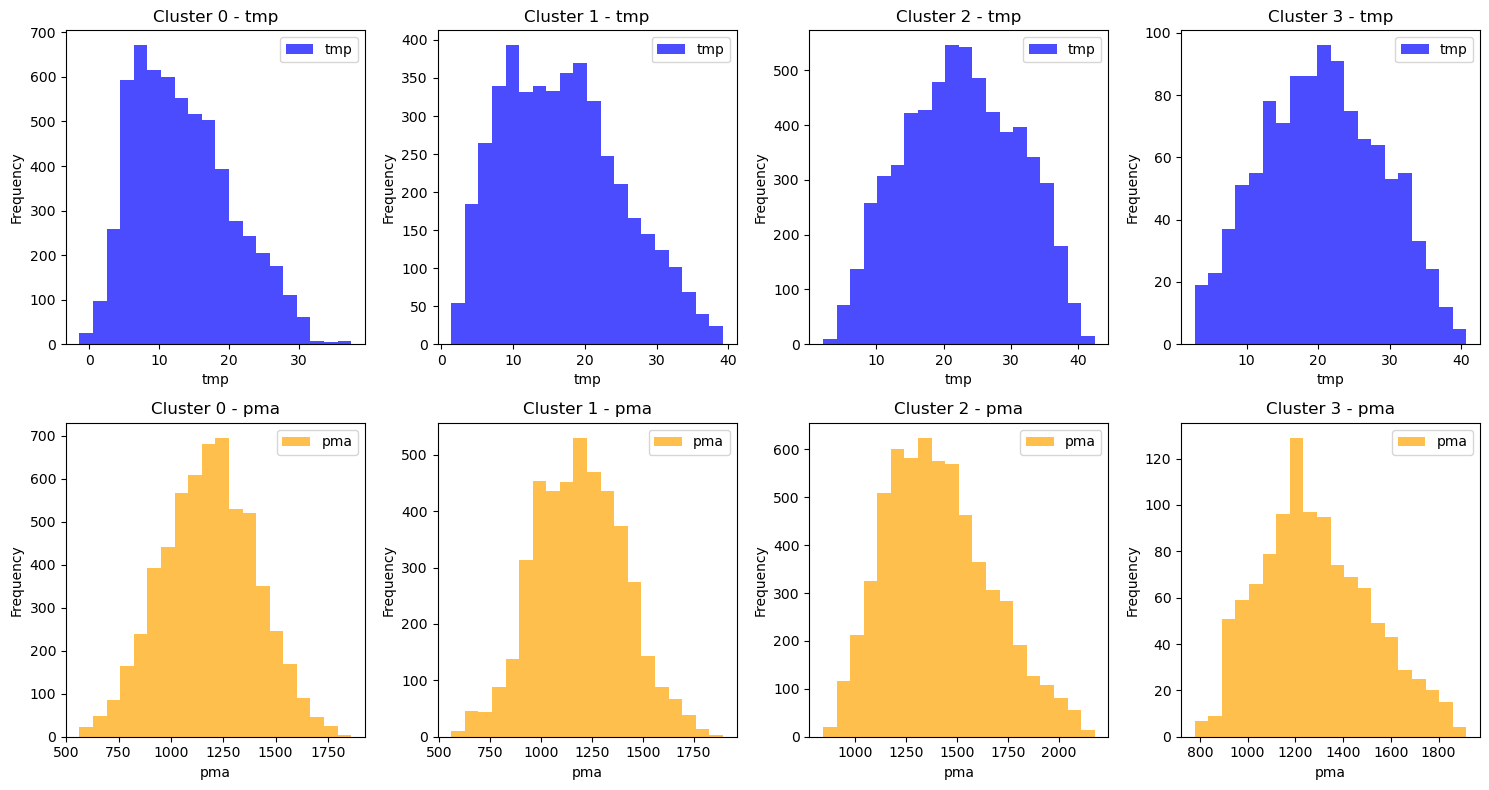

In [69]:
cluster_dataframes = [df[df['cluster_label'] == cluster].drop('cluster_label', axis=1) for cluster in range(5)]  # Adjust the range
# Draw histograms for 'tmp' and 'pma' for each cluster
plt.figure(figsize=(15, 8))

for cluster in range(4):
    plt.subplot(2, 4, cluster+1)  # Adjust the range based on the number of clusters
    plt.hist(cluster_dataframes[cluster]['tmp'], bins=20, color='blue', alpha=0.7, label='tmp')
    plt.title(f'Cluster {cluster} - tmp')
    plt.xlabel('tmp')
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(2, 4, cluster+5)  # Adjust the range based on the number of clusters
    plt.hist(cluster_dataframes[cluster]['pma'], bins=20, color='orange', alpha=0.7, label='pma')
    plt.title(f'Cluster {cluster} - pma')
    plt.xlabel('pma')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

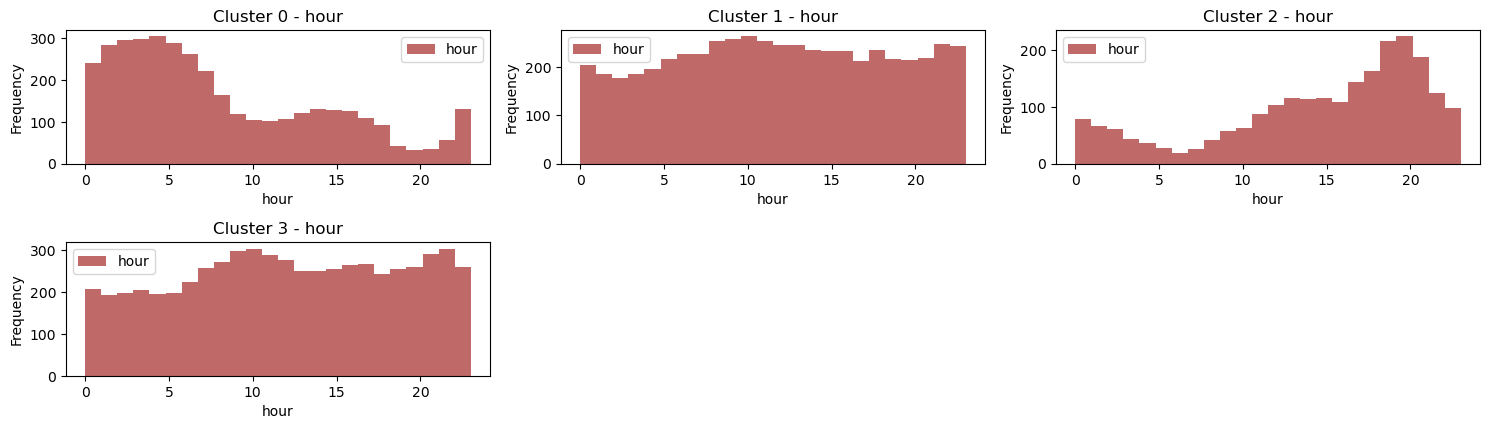

In [70]:
cluster_dataframes = [df[df['cluster'] == cluster].drop('cluster', axis=1) for cluster in range(5)]  # Adjust the range

plt.figure(figsize=(15, 8))
for cluster in range(4):
    plt.subplot(4, 3, cluster+4)   
    plt.hist(cluster_dataframes[cluster]['hour'], bins=24, color='brown', alpha=0.7, label='hour')
    plt.title(f'Cluster {cluster} - hour')   
    plt.xlabel('hour')
    plt.ylabel('Frequency')   
    plt.legend()
plt.tight_layout()
plt.show()

As an obvious observation, for cluster 1 and cluster 2 bacause its is for  weekend and holidays, in contrary to cluster 0 and cluster 2.

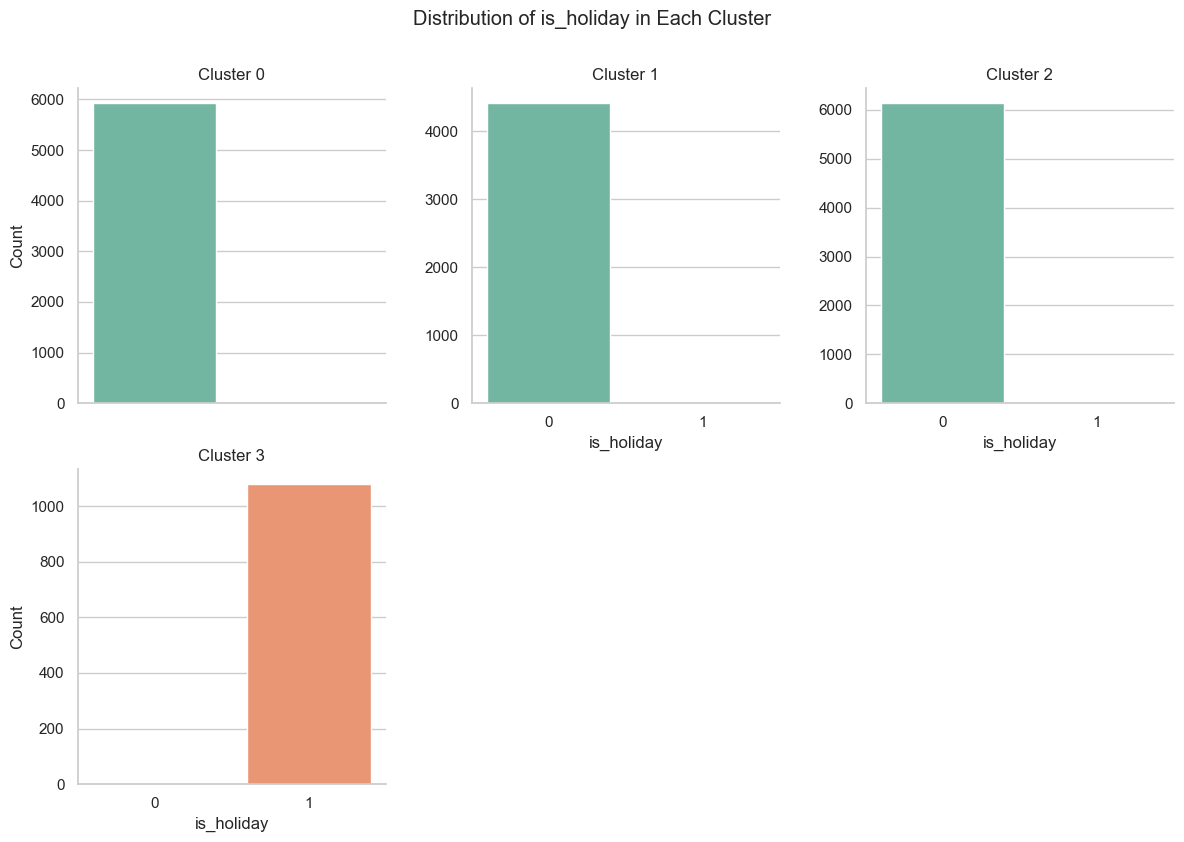

In [71]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Create a FacetGrid to plot each cluster separately
g = sns.FacetGrid(df, col="cluster_label", col_wrap=3, height=4, sharey=False)

# Draw bar plots for 'is_holiday' in each cluster
g.map(sns.countplot, 'is_holiday', palette='Set2', order=[0, 1])
g.set_axis_labels('is_holiday', 'Count')
g.set_titles(col_template='Cluster {col_name}')

# Add title
g.fig.suptitle('Distribution of is_holiday in Each Cluster', y=1.05)

# Show the plot
plt.show()

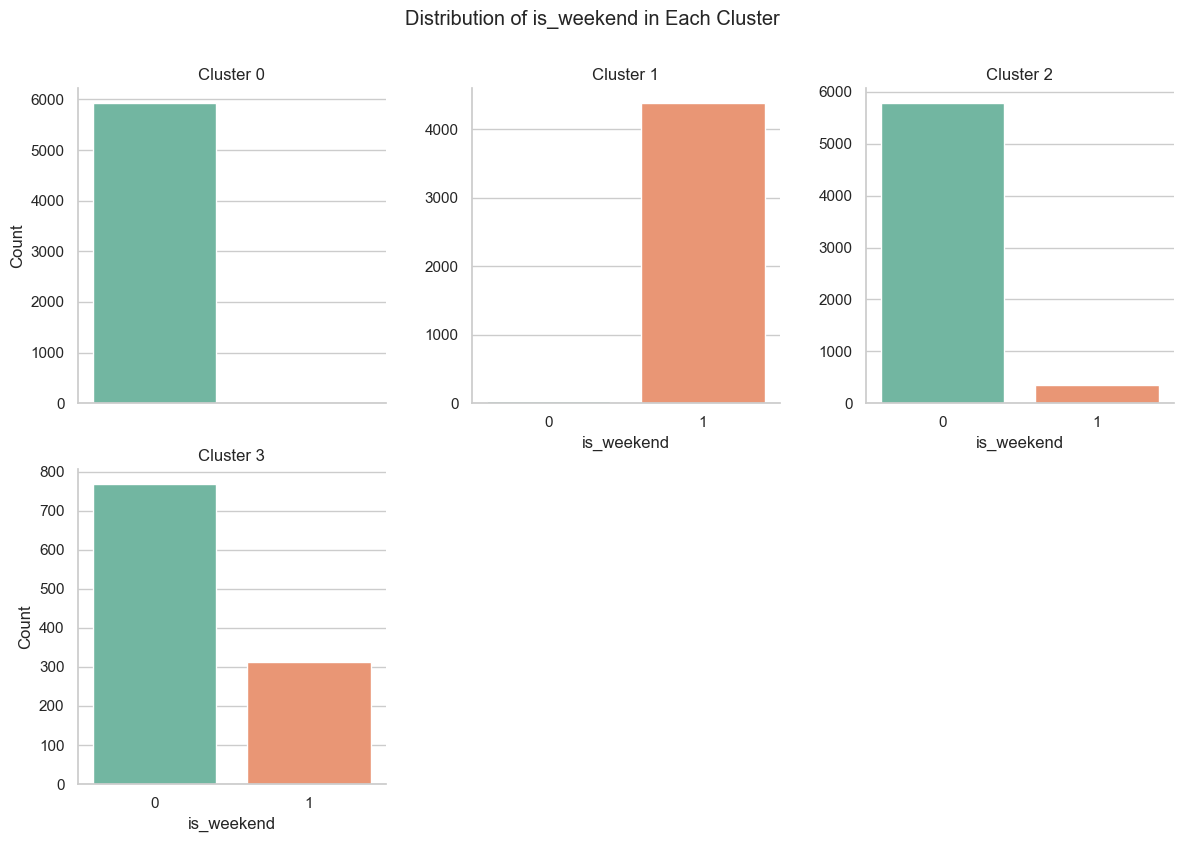

In [72]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Create a FacetGrid to plot each cluster separately
g = sns.FacetGrid(df, col="cluster_label", col_wrap=3, height=4, sharey=False)

# Draw bar plots for 'is_weekend' in each cluster
g.map(sns.countplot, 'is_weekend', palette='Set2', order=[0, 1])
g.set_axis_labels('is_weekend', 'Count')
g.set_titles(col_template='Cluster {col_name}')

# Add title
g.fig.suptitle('Distribution of is_weekend in Each Cluster', y=1.05)

# Show the plot
plt.show()


The previous visualization confirms the impact of each label in their assigned cluster.

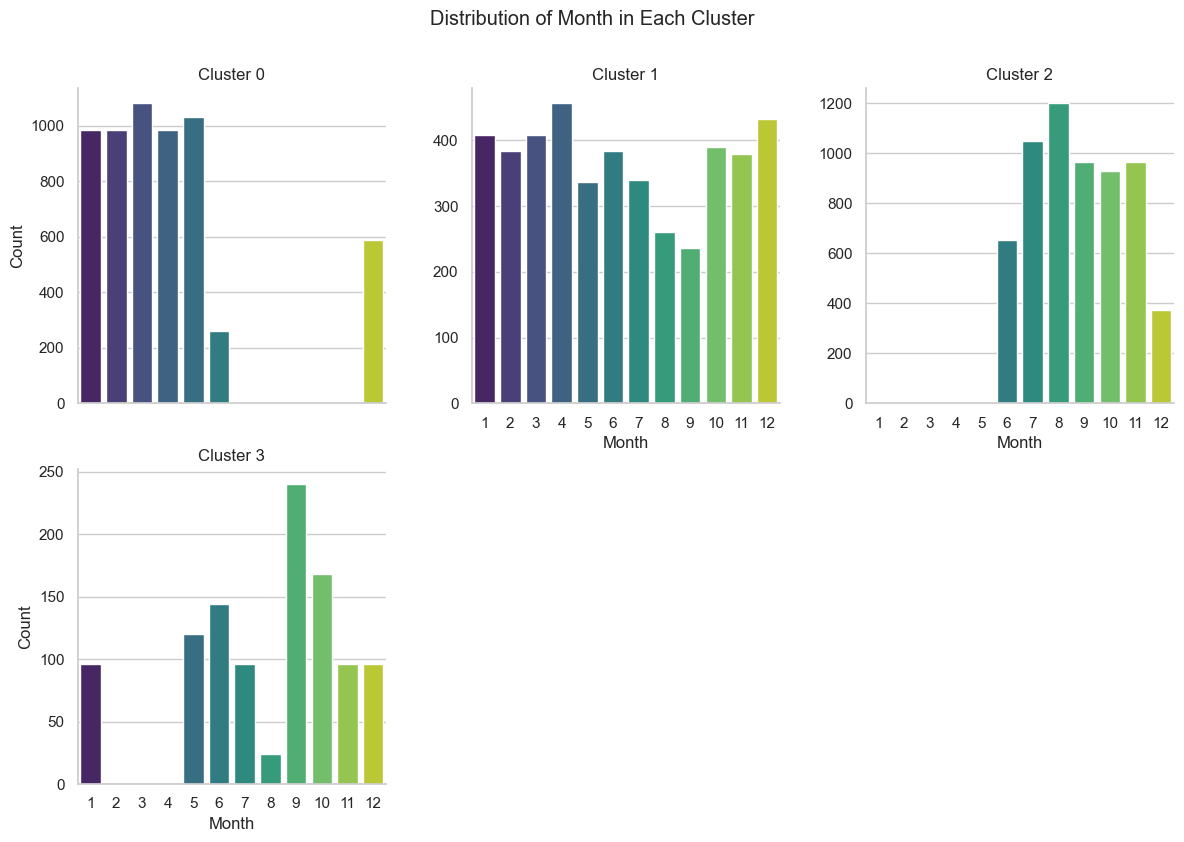

In [73]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Create a FacetGrid to plot each cluster separately
g = sns.FacetGrid(df, col="cluster_label", col_wrap=3, height=4, sharey=False)

# Draw bar plots for 'month' in each cluster
g.map(sns.countplot, 'month', palette='viridis', order=range(1, 13))
g.set_axis_labels('Month', 'Count')
g.set_titles(col_template='Cluster {col_name}')

# Add title
g.fig.suptitle('Distribution of Month in Each Cluster', y=1.05)

# Show the plot
plt.show()


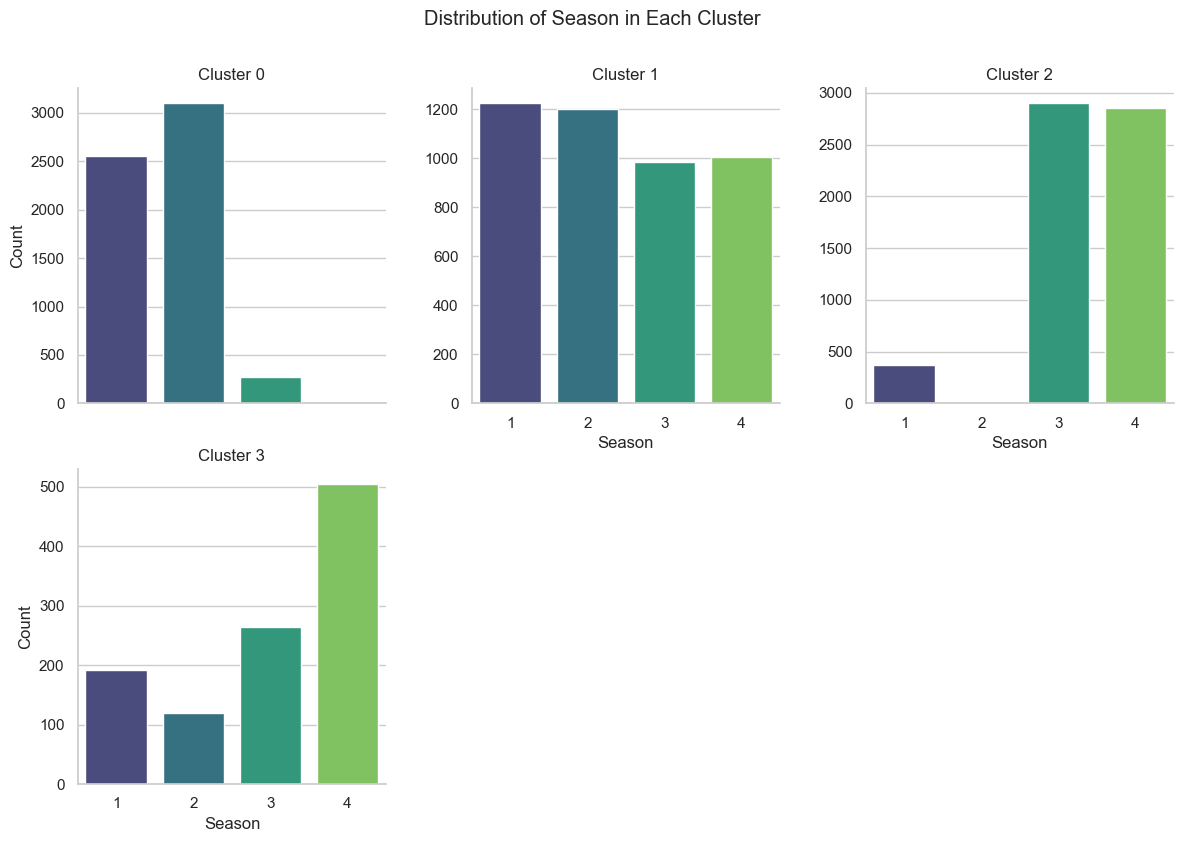

In [74]:
sns.set(style="whitegrid")

# Create a FacetGrid to plot each cluster separately
g = sns.FacetGrid(df, col="cluster_label", col_wrap=3, height=4, sharey=False)

# Draw bar plots for 'season' in each cluster
g.map(sns.countplot, 'season', palette='viridis', order=range(1, 5))
g.set_axis_labels('Season', 'Count')
g.set_titles(col_template='Cluster {col_name}')

# Add title
g.fig.suptitle('Distribution of Season in Each Cluster', y=1.05)

# Show the plot
plt.show()

In this step, we confirmed the impact of season in the remaininf clusters.

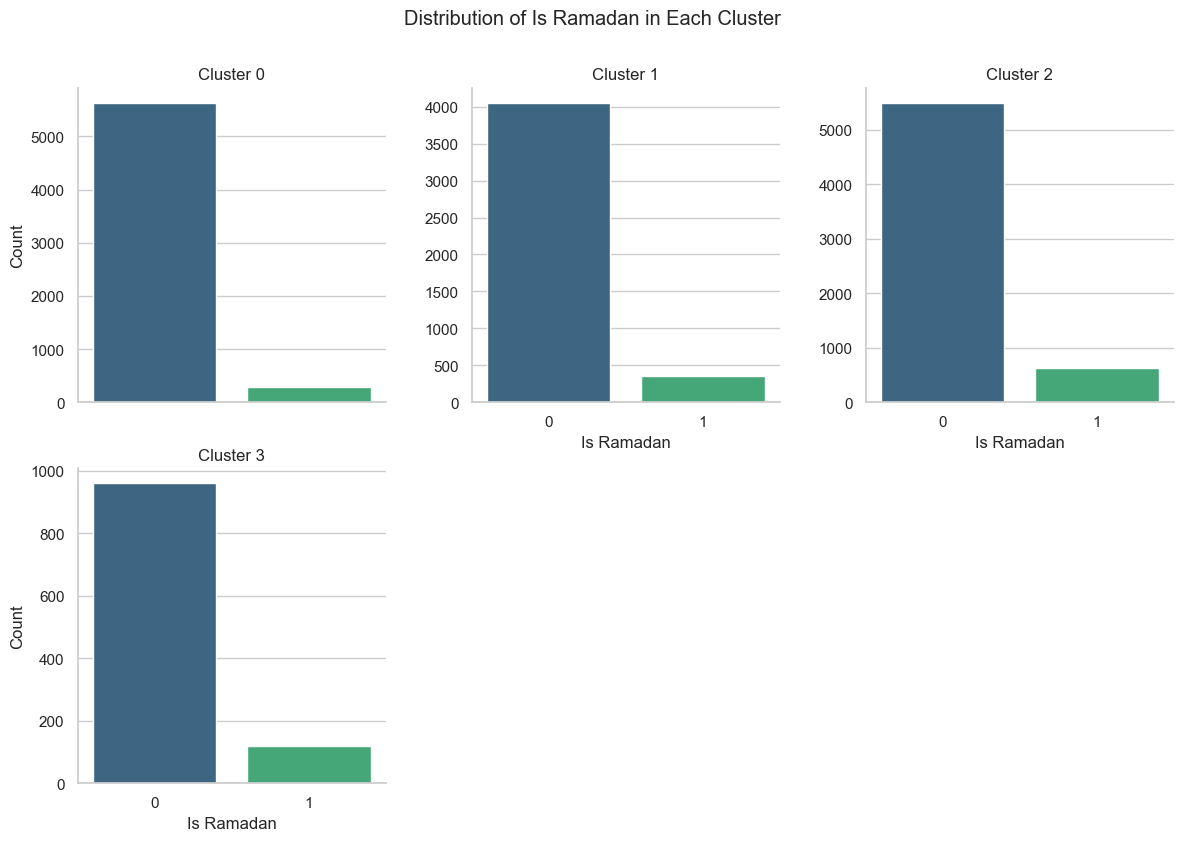

In [75]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Create a FacetGrid to plot each cluster separately
g = sns.FacetGrid(df, col="cluster_label", col_wrap=3, height=4, sharey=False)

# Draw count plots for 'is_ramadan' in each cluster
g.map(sns.countplot, 'is_ramadan', palette='viridis')
g.set_axis_labels('Is Ramadan', 'Count')
g.set_titles(col_template='Cluster {col_name}')

# Add title
g.fig.suptitle('Distribution of Is Ramadan in Each Cluster', y=1.05)

# Show the plot
plt.show()


Here wwe wanted to visualize the impact of Ramdan on each cluster; and as noticed, it doesn'treally affect any of them.

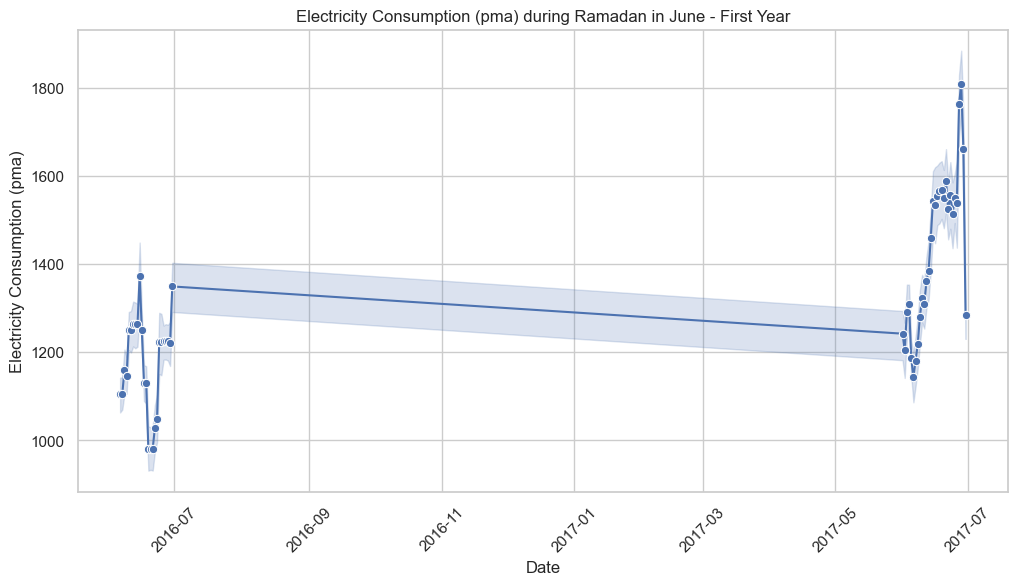

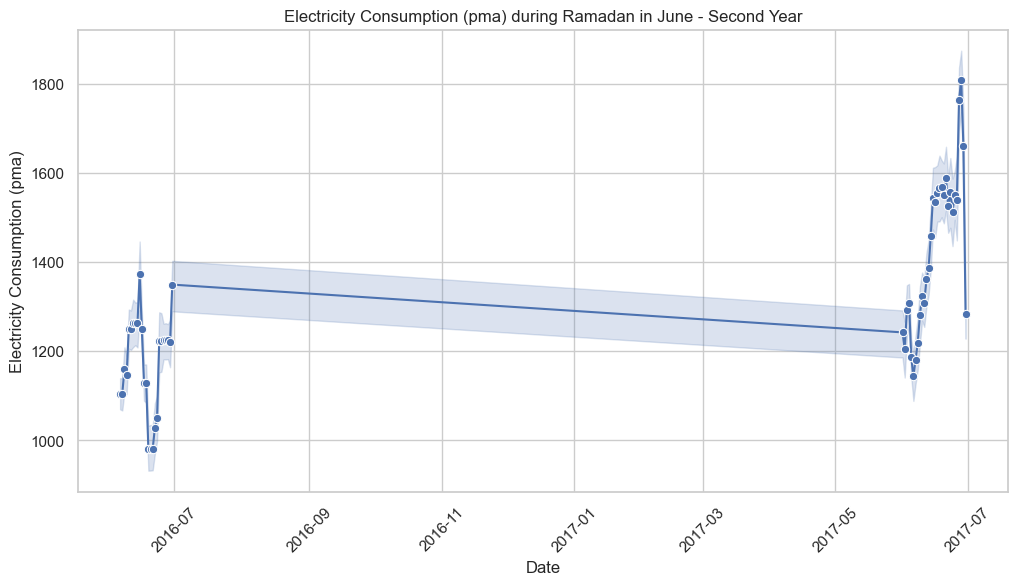

In [76]:
# Convert 'date' column to datetime if it's not already
df['date'] = pd.to_datetime(df['date'])

# Function to identify the start of Ramadan
def is_first_day_of_ramadan(gregorian_date):
    gregorian_datetime = gregorian_date.to_pydatetime()
    year, month, day = gregorian_datetime.year, gregorian_datetime.month, gregorian_datetime.day
    hijri_date = convert.Gregorian(year, month, day).to_hijri()

    # Check if it's the first day of Ramadan (month 9 in the Hijri calendar)
    return hijri_date.month == 9

# Find all occurrences of the start of Ramadan
ramadan_start_dates = [date for date in df['date'] if is_first_day_of_ramadan(date)]

# Filter data for the Ramadan period in the first and second years
first_year_start_date = ramadan_start_dates[0]
second_year_start_date = ramadan_start_dates[1]

# Filter data for Ramadan in June for the first year
ramadan_first_year_df = df[(df['date'] >= first_year_start_date) & (df['date'].dt.month == 6)]
ramadan_second_year_df = df[(df['date'] >= second_year_start_date) & (df['date'].dt.month == 6)]

# Plot for Ramadan in June for the first year
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='pma', data=ramadan_first_year_df, marker='o')
plt.title(f'Electricity Consumption (pma) during Ramadan in June - First Year')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption (pma)')
plt.xticks(rotation=45)
plt.show()

# Plot for Ramadan in June for the second year
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='pma', data=ramadan_second_year_df, marker='o')
plt.title(f'Electricity Consumption (pma) during Ramadan in June - Second Year')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption (pma)')
plt.xticks(rotation=45)
plt.show()


### Cluster 0: Moderate Demand, Moderate Temperature, Weekdays

- PMA: Moderate maximum power demand (1182.86 MW).
- Temperature: Moderate temperature (13.49°C).
- Hour: Peak hours around 11:16 AM.
- Season: Winter and Spring.
- Day of Week: Mostly on Tuesday.
- Weekend: Not common (0%).
- Holiday: Not common (0%).

---

### Cluster 1: Moderate to High Demand, Warm Temperature, Weekends

- PMA: Moderate to high maximum power demand (1190.92 MW).
- Temperature: Warm temperature (16.91°C).
- Hour: Peak hours around 11:00 AM.
- Month: No dominance.
- Day of Week: Mostly on Thursday.
- Season: Primarily in Summer and Fall.
- Weekend: Common (99.14%).
- Holiday: Not common (0%).

---

### Cluster 2: High Demand, High Temperature, Weekdays

- PMA: High maximum power demand (1410.22 MW).
- Temperature: Hot temperature (22.59°C).
- Hour: Peak hours around 12:07 PM.
- Month: From June to December.
- Day of Week: Mostly on Tuesday.
- Season: Primarily in Summer.
- Weekend: Somewhat rare (5.76%).
- Holiday: Not common (0%).

---

### Cluster 3: Moderate Demand, High Temperature, Holidays

- PMA: Moderate maximum power demand (1284.56 MW).
- Temperature: High temperature (20.62°C).
- Hour: Peak hours around 11:30 AM.
- Month: Mostly in July.
- Day of Week: No specific day dominance.
- Season: Primarily in Summer.
- Weekend: Occasional (28.89%).
- Holiday: Common (100%).

# Project Conclusion

In conclusion, the project has successfully navigated through the intricate process of identifying day types in the Algerian electricity load. Leveraging extensive data analysis, visualization, and clustering techniques, we uncovered nuanced patterns within the dataset. The inclusion of essential attributes, such as 'is_ramadan, is_weekend, is_holiday' significantly enhanced our ability to distinguish day types accurately.

The clustering process, informed by careful consideration of feature relevance and aided by visualization, yielded well-defined clusters that align with our designated labels. This robust clustering was further validated through separate cluster visualizations, affirming the accuracy and meaningfulness of our results.

Overall, the project demonstrates a comprehensive approach to understanding and classifying day types in the context of Algerian electricity load. The insights gained from this analysis not only contribute to a better understanding of consumption patterns but also lay the foundation for more informed decision-making in the realm of energy management and resource allocation.